In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [1]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#reads in california constitution

#i need to clean the data more

with open('../DATA/2020.txt', 'r') as f:
    data = f.read()

In [3]:
data

'BAD BOYS 3 \nPrevious Draft  \nby \nPeter Craig \nCurrent Draft \nby \nDavid Guggenheim \nNovember 12, 2014\nFADE IN: \nEXT. BURREL PRISON - NIGHT \nStone walls. Gun towers. Razor wire. A formidable hellhole.  SUPER: BURREL PRISON - ALBANIA \nA KAWASAKI NINJA 300 FLIES UP to the prison gates.  \nTWO GUARDS watch as a silky figure climbs off the bike and  removes her helmet to reveal a gorgeous head of red hair.  \nDialogue in ITALICS is in ALBANIAN with ENGLISH SUBTITLES: \nGATE GUARD \nYou lose your way?  \nGIRL \nNo, I’m right where I need to be.  \nShe unzips her jacket. Is she gonna flash them? But then she  pulls out two ENVELOPES.  \nConfused, the guards open them up. They’re filled with  AMERICAN DOLLARS. \nGIRL (CONT’D) \nAleksander Luga. Inmate 2-1-9-5. I  \nwant him free.  \nThe guards trade looks. Go to hand the money back. \nGATE GUARD \nGet the fuck out of here. \nGIRL \nJust know... We gave you the easy  \nway out. \nTwin precision shots rip through the guards foreheads.

In [4]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [5]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [6]:
data = data.split("\n")    

In [7]:
data = [item for item in data if item != '']

In [8]:
data

['BAD BOYS  ',
 'Previous  Draft  ',
 'by ',
 'Peter  Craig ',
 ' Current  Draft ',
 'by ',
 ' David Guggenheim ',
 'November , ',
 'FADE  IN: ',
 'EXT. BURREL PRISON - NIGHT ',
 'Stone walls. Gun towers. Razor wire. A formidable hellhole.  SUPER: BURREL PRISON - ALBANIA ',
 'A KAWASAKI NINJA  FLIES UP to the prison gates.  ',
 'TWO GUARDS watch as a silky figure climbs off the bike and  removes her helmet to reveal a gorgeous head of red hair.  ',
 ' Dialogue in  ITALICS is in ALBANIAN with ENGLISH SUBTITLES: ',
 'GATE GUARD ',
 'You lose your way?  ',
 'GIRL ',
 'No,  ’m right where   need to be.  ',
 'She unzips her jacket.  Is she gonna flash them? But then she  pulls out two ENVELOPES.  ',
 ' Confused, the guards open them up. They’re filled with  AMERICAN  DOLLARS. ',
 'GIRL ( CONT’ ) ',
 'Aleksander  Luga.  Inmate ---.    ',
 'want him free.  ',
 'The guards trade looks. Go to hand the money back. ',
 'GATE GUARD ',
 'Get the fuck out of here. ',
 'GIRL ',
 'Just know... We gave

In [9]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/572 [00:00<?, ?it/s]

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable

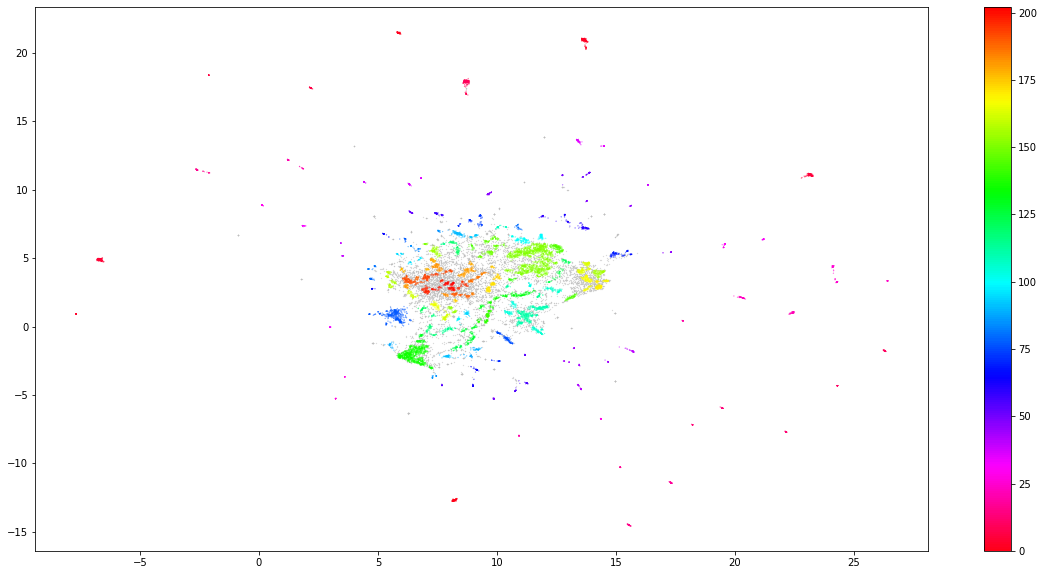

In [12]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [13]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
docs_per_topic

,Topic,Doc
0,-1,Previous Draft Dialogue in ITALICS is in ...
1,0,by by . . . . . . . . . . . . . . . . . . . ...
2,1,MARCUS MARCUS MARCUS MARCUS MARCUS ...
3,2,Peter Craig IAN IAN IAN IAN IAN L...
4,3,CROSBY CROSBY CROSBY CROSBY CROSBY ...
...,...,...
199,198,partnered up. You know what can what we ca...
200,199,’ll tell you when we get there. you enough f...
201,200,"Yeah, got it. glass and we can make this ha..."
202,201,Hess sent us. We’re to take -- Of course. We’...


In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/sx/mxg316554p53ftfz37jrsvnr0000gn/T/ipykernel_92963/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [20]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

,Topic,Size
0,-1,5902
152,151,1360
136,135,809
78,77,418
112,111,254
3,2,238
5,4,222
10,9,220
6,5,193
146,145,168


In [23]:
len(top_n_words)

204

In [26]:
index = [151,135,77,111,2,4,9,5,145]

In [27]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:7])
    print()

Topic # 150
[('away', 0.0679047068556599), ('stop', 0.06586924699532505), ('bad', 0.05976354297132052), ('wrong', 0.05242652673117769), ('just', 0.052228200325911), ('lost', 0.05073067417820368), ('weird', 0.04054086705169836)]

Topic # 134
[('ian', 0.06434198933733497), ('mike', 0.06255714262428388), ('protagonist', 0.05077923424114036), ('marcus', 0.04750415037601841), ('barley', 0.044294870103107994), ('pulls', 0.04306983130620874), ('door', 0.041032947953813105)]

Topic # 76
[('girl', 0.21012327194885003), ('woman', 0.14055264469745482), ('mum', 0.13677912651707252), ('mom', 0.12396603641950775), ('cecilia', 0.12323735984447966), ('kat', 0.1081292346109797), ('mother', 0.1050557303417048)]

Topic # 110
[('good', 0.46764735001652413), ('great', 0.24459509924036832), ('nice', 0.21684532308839183), ('happy', 0.1784966884616527), ('pretty', 0.1538067048389792), ('amazing', 0.11841983635292537), ('beautiful', 0.11310440694473725)]

Topic # 1
[('ian', 3.1428589515845866), ('whispered', 0